In [2]:
!pip install --user dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 9.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 9.2 MB/s eta 0:00:0000:0100:01


In [3]:
import pandas as pd
import numpy as np
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

# Load data
data = pd.read_csv('Compiled_Networks_4.csv')

# Filter data for DIV 24 and neuron types WT and HET
filtered_data = data[(data['DIV'] == 24) & (data['NeuronType'].isin(['WT cortex', 'HET cortex']))]

# List of metrics to plot histograms for
metrics = ['IBI', 'Burst_Peak', 'Number_Bursts', 'Spike_per_Burst', 'BurstDuration']

# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='metric-dropdown',
        options=[{'label': metric, 'value': metric} for metric in metrics],
        value='IBI'
    ),
    dcc.Graph(id='histogram-graph')
])

@app.callback(
    Output('histogram-graph', 'figure'),
    Input('metric-dropdown', 'value'))
def update_graph(selected_metric):
    wt_data = filtered_data[filtered_data['NeuronType'] == 'WT cortex'][selected_metric]
    het_data = filtered_data[filtered_data['NeuronType'] == 'HET cortex'][selected_metric]

    # Calculate bins for histogram
    bins = np.histogram(np.hstack((wt_data, het_data)), bins=20)[1]

    # Calculate histogram for WT and HET
    wt_counts, _ = np.histogram(wt_data, bins=bins)
    het_counts, _ = np.histogram(het_data, bins=bins)

    # Calculate bar width
    width = (bins[1] - bins[0]) * 0.4

    # Bar centers
    wt_bin_centers = bins[:-1] + width
    het_bin_centers = bins[:-1] + width * 2

    # Create the graph
    fig = go.Figure()
    fig.add_trace(go.Bar(x=wt_bin_centers, y=wt_counts, width=width, name='WT', marker_color='blue'))
    fig.add_trace(go.Bar(x=het_bin_centers, y=het_counts, width=width, name='HET', marker_color='red'))

    # Add mean lines
    mean_wt = np.mean(wt_data)
    mean_het = np.mean(het_data)
    fig.add_shape(type='line', x0=mean_wt, x1=mean_wt, y0=0, y1=max(wt_counts), line=dict(color='blue', dash='dash'))
    fig.add_shape(type='line', x0=mean_het, x1=mean_het, y0=0, y1=max(het_counts), line=dict(color='red', dash='dash'))

    fig.update_layout(title=f'Distribution of {selected_metric}', xaxis_title=selected_metric, yaxis_title='Frequency', barmode='overlay')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/kx/v7vqz39d5nn79sxpbgh1vn3w0000gn/T/ipykernel_47956/1861163535.py:4: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/var/folders/kx/v7vqz39d5nn79sxpbgh1vn3w0000gn/T/ipykernel_47956/1861163535.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [1]:
#giving the option for svg only and sem or mean
import pandas as pd
import numpy as np
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import socket

# Load data
data = pd.read_csv('Compiled_Networks_4.csv')  # Ensure to change the path as needed

# Extract unique DIVs from the dataset
unique_divs = sorted(data['DIV'].unique())

# Define available metrics
metrics = ['IBI', 'Burst_Peak', 'Number_Bursts', 'Spike_per_Burst', 'BurstDuration']

# Initialize the Dash app
app = dash.Dash(__name__)

# App layout
app.layout = html.Div([
    dcc.Checklist(
        id='div-checklist',
        options=[{'label': str(div), 'value': div} for div in unique_divs],
        value=unique_divs,  # Default all DIVs selected
        inline=True
    ),
    dcc.Dropdown(
        id='plot-type-dropdown',
        options=[
            {'label': 'Bar Graph', 'value': 'bar'},
            {'label': 'Histogram', 'value': 'hist'},
            {'label': 'Line Plot', 'value': 'line'}
        ],
        value='bar'
    ),
    dcc.Dropdown(
        id='metric-dropdown',
        options=[{'label': metric, 'value': metric} for metric in metrics],
        value='IBI'
    ),
    dcc.Dropdown(
        id='statistic-type-dropdown',
        options=[
            {'label': 'Mean', 'value': 'mean'},
            {'label': 'Standard Error of the Mean', 'value': 'sem'}
        ],
        value='mean'
    ),
        dcc.Graph(
        id='data-graph',
        config={
            'toImageButtonOptions': {
                'format': 'svg',
                'filename': 'custom_image',
                'height': 600,
                'width': 1200,
                'scale': 1
            },
            'displaylogo': False,
            'modeBarButtonsToAdd': ['toImage']
        }
    )
])

# Callbacks to update the graph
@app.callback(
    Output('data-graph', 'figure'),
    [Input('div-checklist', 'value'),
     Input('plot-type-dropdown', 'value'),
     Input('metric-dropdown', 'value'),
     Input('statistic-type-dropdown', 'value')])
def update_graph(selected_divs, plot_type, selected_metric, stat_type):
    filtered_data = data[data['DIV'].isin(selected_divs) & data['NeuronType'].isin(['WT cortex', 'HET cortex'])]

    fig = go.Figure()

    if plot_type == 'bar':
        # Calculate mean or SEM based on selection
        if stat_type == 'mean':
            summary_stats = filtered_data.groupby(['DIV', 'NeuronType'])[selected_metric].mean().unstack()
            errors = None
        else:
            summary_stats = filtered_data.groupby(['DIV', 'NeuronType'])[selected_metric].sem().unstack()
            errors = filtered_data.groupby(['DIV', 'NeuronType'])[selected_metric].sem().unstack()
        
        for idx, neuron_type in enumerate(['WT cortex', 'HET cortex']):
            fig.add_trace(go.Bar(
                x=selected_divs,
                y=summary_stats.get(neuron_type, pd.Series(index=selected_divs, data=np.nan)).values,
                name=neuron_type,
                offsetgroup=idx,
                error_y=dict(type='data', array=errors.get(neuron_type, pd.Series(index=selected_divs, data=np.nan)).values if errors is not None else None, visible=True)
            ))
        fig.update_layout(barmode='group')
    
    elif plot_type == 'hist':
        # Calculating bin size and edges for histograms
        global_min = filtered_data[selected_metric].min()
        global_max = filtered_data[selected_metric].max()
        bins = np.linspace(global_min, global_max, 21)  # 20 bins
        for neuron_type in ['WT cortex', 'HET cortex']:
            for div in selected_divs:
                div_data = filtered_data[(filtered_data['DIV'] == div) & (filtered_data['NeuronType'] == neuron_type)][selected_metric]
                fig.add_trace(go.Histogram(
                    x=div_data,
                    name=f'{neuron_type} DIV {div}',
                    xbins=dict(start=bins[0], end=bins[-1], size=(bins[1]-bins[0])),
                    opacity=0.75
                ))
        fig.update_layout(barmode='overlay')
    
    elif plot_type == 'line':
        means = filtered_data.groupby(['DIV', 'NeuronType'])[selected_metric].mean().unstack()
        for neuron_type in ['WT cortex', 'HET cortex']:
            fig.add_trace(go.Scatter(
                x=selected_divs,
                y=means.get(neuron_type, pd.Series(index=selected_divs, data=np.nan)).values,
                name=neuron_type,
                mode='lines+markers'
            ))
    
    fig.update_layout(
        title=f'{selected_metric} by DIV using {stat_type.upper()}',
        xaxis_title='DIV',
        yaxis_title=f'{stat_type.upper()} of {selected_metric}',
        xaxis={'type': 'category'}
    )
    return fig

def find_free_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind(('', 0))
    port = s.getsockname()[1]
    s.close()
    return port

# Run the app on an available port
if __name__ == '__main__':
    free_port = find_free_port()
    app.run_server(debug=True, port=free_port)


In [1]:
#option for svg,png, mean and sem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load data
data = pd.read_csv('/mnt/data/Compiled_Networks_4.csv')

# Extract unique DIVs from the dataset
unique_divs = sorted(data['DIV'].unique())

# Define available metrics
metrics = ['IBI', 'Burst_Peak', 'Number_Bursts', 'Spike_per_Burst', 'BurstDuration']

# Define plot type and metric for plotting
plot_type = 'bar'  # Choose from 'bar', 'hist', 'line'
selected_metric = 'IBI'
stat_type = 'mean'  # Choose from 'mean', 'sem'

# Filtered data
filtered_data = data[data['DIV'].isin(unique_divs) & data['NeuronType'].isin(['WT cortex', 'HET cortex'])]

colors = {'WT cortex': 'blue', 'HET cortex': 'red'}

# Plotting
plt.figure(figsize=(12, 6))

if plot_type == 'bar':
    summary_stats = filtered_data.groupby(['DIV', 'NeuronType'])[selected_metric].agg(['mean', 'sem']).unstack()
    bar_width = 0.35
    index = np.arange(len(unique_divs))
    
    for i, neuron_type in enumerate(['WT cortex', 'HET cortex']):
        means = summary_stats['mean'][neuron_type]
        sems = summary_stats['sem'][neuron_type]
        plt.bar(index + i * bar_width, means.values, bar_width, label=neuron_type.split()[0], yerr=sems.values, color=colors[neuron_type])
        
        # Perform t-tests and add significance annotations
        for j, div in enumerate(unique_divs):
            if div in means.index:
                wt_data = filtered_data[(filtered_data['DIV'] == div) & (filtered_data['NeuronType'] == 'WT cortex')][selected_metric]
                het_data = filtered_data[(filtered_data['DIV'] == div) & (filtered_data['NeuronType'] == 'HET cortex')][selected_metric]
                _, p_value = ttest_ind(wt_data.dropna(), het_data.dropna(), equal_var=False)
                sig_symbol = ''
                if p_value < 0.001:
                    sig_symbol = '***'
                elif p_value < 0.01:
                    sig_symbol = '**'
                elif p_value < 0.05:
                    sig_symbol = '*'
                if sig_symbol:
                    plt.text(j + i * bar_width, max(means[div] + sems[div], means[div] + sems[div]) + 0.05, sig_symbol, ha='center')

    plt.xlabel('DIV')
    plt.ylabel(f'{stat_type.upper()} of {selected_metric}')
    plt.title(f'{selected_metric} by DIV using {stat_type.upper()}')
    plt.xticks(index + bar_width / 2, unique_divs)
    plt.legend(title='Neuron Type')

elif plot_type == 'hist':
    for neuron_type in ['WT cortex', 'HET cortex']:
        for div in unique_divs:
            div_data = filtered_data[(filtered_data['DIV'] == div) & (filtered_data['NeuronType'] == neuron_type)][selected_metric]
            sns.histplot(div_data, kde=False, label=f'{neuron_type} DIV {div}', color=colors[neuron_type], alpha=0.75)

    plt.xlabel(selected_metric)
    plt.ylabel('Count')
    plt.title(f'Histogram of {selected_metric} by DIV')
    plt.legend(title='Neuron Type and DIV')

elif plot_type == 'line':
    for neuron_type in ['WT cortex', 'HET cortex']:
        mean_vals = filtered_data[filtered_data['NeuronType'] == neuron_type].groupby('DIV')[selected_metric].mean()
        plt.plot(unique_divs, [mean_vals.get(div, None) for div in unique_divs], marker='o', label=neuron_type, color=colors[neuron_type])

    plt.xlabel('DIV')
    plt.ylabel(f'{stat_type.upper()} of {selected_metric}')
    plt.title(f'{selected_metric} by DIV using {stat_type.upper()}')
    plt.legend(title='Neuron Type')

plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Compiled_Networks_4.csv'

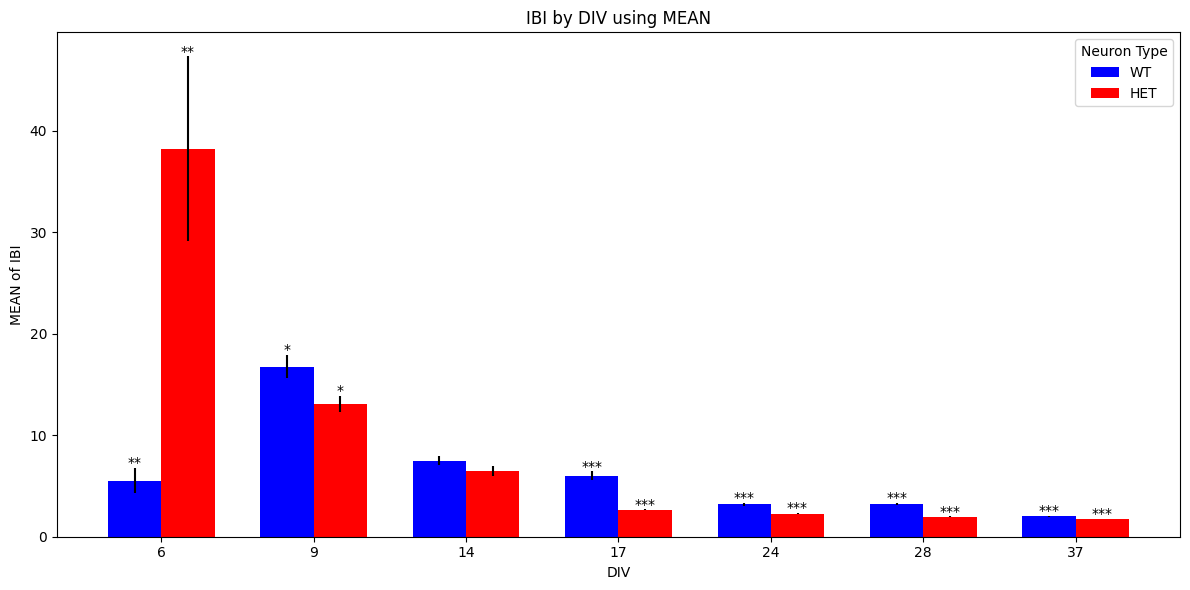

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load data
data = pd.read_csv('Compiled_Networks_4.csv')

# Extract unique DIVs from the dataset
unique_divs = sorted(data['DIV'].unique())

# Define available metrics
metrics = ['IBI', 'Burst_Peak', 'Number_Bursts', 'Spike_per_Burst', 'BurstDuration']

# Define plot type and metric for plotting
plot_type = 'bar'  # Choose from 'bar', 'hist', 'line'
selected_metric = 'IBI'
stat_type = 'mean'  # Choose from 'mean', 'sem'

# Filtered data
filtered_data = data[data['DIV'].isin(unique_divs) & data['NeuronType'].isin(['WT cortex', 'HET cortex'])]

colors = {'WT cortex': 'blue', 'HET cortex': 'red'}

# Plotting
plt.figure(figsize=(12, 6))

if plot_type == 'bar':
    summary_stats = filtered_data.groupby(['DIV', 'NeuronType'])[selected_metric].agg(['mean', 'sem']).unstack()
    bar_width = 0.35
    index = np.arange(len(unique_divs))
    
    for i, neuron_type in enumerate(['WT cortex', 'HET cortex']):
        means = summary_stats['mean'][neuron_type]
        sems = summary_stats['sem'][neuron_type]
        plt.bar(index + i * bar_width, means.values, bar_width, label=neuron_type.split()[0], yerr=sems.values, color=colors[neuron_type])
        
        # Perform t-tests and add significance annotations
        for j, div in enumerate(unique_divs):
            if div in means.index:
                wt_data = filtered_data[(filtered_data['DIV'] == div) & (filtered_data['NeuronType'] == 'WT cortex')][selected_metric]
                het_data = filtered_data[(filtered_data['DIV'] == div) & (filtered_data['NeuronType'] == 'HET cortex')][selected_metric]
                _, p_value = ttest_ind(wt_data.dropna(), het_data.dropna(), equal_var=False)
                sig_symbol = ''
                if p_value < 0.001:
                    sig_symbol = '***'
                elif p_value < 0.01:
                    sig_symbol = '**'
                elif p_value < 0.05:
                    sig_symbol = '*'
                if sig_symbol:
                    plt.text(j + i * bar_width, max(means[div] + sems[div], means[div] + sems[div]) + 0.05, sig_symbol, ha='center')

    plt.xlabel('DIV')
    plt.ylabel(f'{stat_type.upper()} of {selected_metric}')
    plt.title(f'{selected_metric} by DIV using {stat_type.upper()}')
    plt.xticks(index + bar_width / 2, unique_divs)
    plt.legend(title='Neuron Type')

elif plot_type == 'hist':
    for neuron_type in ['WT cortex', 'HET cortex']:
        for div in unique_divs:
            div_data = filtered_data[(filtered_data['DIV'] == div) & (filtered_data['NeuronType'] == neuron_type)][selected_metric]
            sns.histplot(div_data, kde=False, label=f'{neuron_type} DIV {div}', color=colors[neuron_type], alpha=0.75)

    plt.xlabel(selected_metric)
    plt.ylabel('Count')
    plt.title(f'Histogram of {selected_metric} by DIV')
    plt.legend(title='Neuron Type and DIV')

elif plot_type == 'line':
    for neuron_type in ['WT cortex', 'HET cortex']:
        mean_vals = filtered_data[filtered_data['NeuronType'] == neuron_type].groupby('DIV')[selected_metric].mean()
        plt.plot(unique_divs, [mean_vals.get(div, None) for div in unique_divs], marker='o', label=neuron_type, color=colors[neuron_type])

    plt.xlabel('DIV')
    plt.ylabel(f'{stat_type.upper()} of {selected_metric}')
    plt.title(f'{selected_metric} by DIV using {stat_type.upper()}')
    plt.legend(title='Neuron Type')

plt.tight_layout()
plt.show()
